# Data conversion script
Convert data from TFRecord with nonstand data format to a standard one

In [1]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from glob import glob
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# frontend imports
from keras_yolov2.yolo_loss import YoloLoss
from keras_yolov2.map_evaluation import MapEvaluation
from keras_yolov2.utils import decode_netout, import_feature_extractor, import_dynamically
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Reshape, Conv2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras_yolov2.frontend import YOLO
from keras_yolov2.preprocessing import BatchGenerator
from keras_yolov2.custom_backend import ResNet50CustomFeature
import numpy as np
import sys
import cv2
import os

# preprocessing imports
import copy
import os
import xml.etree.ElementTree as et

import cv2
import numpy as np
from imgaug import augmenters as iaa
from imgaug.augmentables import BoundingBox, BoundingBoxesOnImage
from tensorflow.keras.utils import Sequence
from tqdm import tqdm

from keras_yolov2.utils import BoundBox, bbox_iou
import random
from tfdeterminism import patch
patch()
SEED = 234534
random.seed(SEED)
tf.random.set_random_seed(SEED)
np.random.seed(SEED)

/vol/tensusers2/sdooper/Anaconda3/envs/dam/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/vol/tensusers2/sdooper/Anaconda3/envs/dam/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/vol/tensusers2/sdooper/Anaconda3/envs/dam/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/vol/tensusers2/sdoope


TensorFlow version 1.14.0 has been patched using tfdeterminism version 0.3.0


In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

## Input configurations

paths to data and config constants

In [3]:
# Yolo class input parameters
config = {
    "model" : {
        "backend":              "./keras_yolov2/custom_backend.ResNet50CustomFeature",
        "input_size_w":         257,
        "input_size_h":         257,
        "gray_mode":            False,
        "anchors":              [0.03502,0.05837, 0.06615,0.03113, 0.08949,0.07004, 0.15953,0.13619, 0.36576,0.31907],
        #"anchors": (transformed, no longer divided by cell_w)             [1.33074, 1.68093, 2.34630, 1.22568, 2.48638, 2.13619, 3.11673, 4.16732, 5.53307, 2.27626],
        # gen anchors (no trans) "anchors":              [5.11111, 4.111111, 9.22222, 11.7777, 15.6666, 6.77777, 8.22222, 4.33333, 4.44444, 7.44444],
        # original "anchors":             [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828],
        "max_box_per_image":    10,        
        "labels":               ["dam"]
    },

    "parser_annotation_type":    "xml",

    "train": {
        "train_csv_file":       "",
        "train_csv_base_path":  "",
        "train_image_folder":   "/vol/tensusers2/sdooper/dam_detection/keras_yolo2/train_image_folder",
        "train_annot_folder":   "/vol/tensusers2/sdooper/dam_detection/keras_yolo2/train_annot_folder",     

        "callback":             None,
        "train_times":          8,
        "pretrained_weights":   "",
        "batch_size":           16,
        "learning_rate":        0.0001,
        "nb_epochs":            40,
        "warmup_epochs":        3,

        "workers":              12,
        "max_queue_size":       40,
        "early_stop":           True,
        "tensorboard_log_dir":  "./logs/1",

        "object_scale":         5.0 ,
        "no_object_scale":      1.0,
        "coord_scale":          1.0,
        "class_scale":          1.0,

        "saved_weights_name":   "tiny_yolo_backend_best.h5",
        "debug":                False
    },

    "valid": {
        "iou_threshold":        "0.5",
        "score_threshold":      "0.5",
        "valid_csv_file":       "",
        "valid_csv_base_path":  "",
        "valid_image_folder":   "/vol/tensusers2/sdooper/dam_detection/keras_yolo2/valid_image_folder",
        "valid_annot_folder":   "/vol/tensusers2/sdooper/dam_detection/keras_yolo2/valid_annot_folder",

        "valid_times":          1
    },

    "backup":{
        "create_backup":        False,
        "redirect_model":       True,
        "backup_path":          "../backup",
        "backup_prefix":        "Tiny_yolo_VOC"
    }
}


input_size = [257,257,5]

In [16]:
input_path = '../datasets/bbox_data/train/*.gz'

input_files= glob(input_path)
#print("input path is ", input_files)
print(input_files[0:10])
print(len(input_files))

['../datasets/bbox_data/train/dam-data-001.gz', '../datasets/bbox_data/train/dam-data-000.gz', '../datasets/bbox_data/train/dam-data-002.gz', '../datasets/bbox_data/train/dam-data-003.gz', '../datasets/bbox_data/train/dam-data-004.gz', '../datasets/bbox_data/train/dam-data-005.gz', '../datasets/bbox_data/train/dam-data-006.gz', '../datasets/bbox_data/train/dam-data-007.gz', '../datasets/bbox_data/train/dam-data-008.gz', '../datasets/bbox_data/train/dam-data-009.gz']
223


In [10]:
def parse_serialized_example(example_proto):
    ''' Parser function
    Useful for functional extraction, i.e. .map functions
    
    Args:
        example_proto: a serialized example
        
    Returns:
        A dictionary with features, cast to float32
        This returns a dictionary of keys and tensors to which I apply the transformations.
    '''
    # feature columns of interest
    featuresDict = {
        'image/height': tf.io.FixedLenFeature(1, dtype=tf.int64),
        'image/width': tf.io.FixedLenFeature(1, dtype=tf.int64),
        'image/filename': tf.io.FixedLenFeature(1, dtype=tf.string),
        'image/source_id': tf.io.FixedLenFeature(1, dtype=tf.string),
        'image/format': tf.io.FixedLenFeature(1, dtype=tf.string),
        'image/channel/B2': tf.io.FixedLenFeature([257, 257], dtype=tf.float32),  # B
        'image/channel/B3': tf.io.FixedLenFeature([257, 257], dtype=tf.float32),  # G
        'image/channel/B4': tf.io.FixedLenFeature([257, 257], dtype=tf.float32),  # R
        'image/channel/AVE': tf.io.FixedLenFeature([257, 257], dtype=tf.float32), # Elevation
        'image/channel/NDWI': tf.io.FixedLenFeature([257, 257], dtype=tf.float32), # water index
        'image/channel/MNDWI': tf.io.FixedLenFeature([257, 257], dtype=tf.float32), # water index
        #'image/channel/AWEINSH': tf.io.FixedLenFeature([257, 257], dtype=tf.float32), # water index
        #'image/channel/AWEISH': tf.io.FixedLenFeature([257, 257], dtype=tf.float32), # water index
        'image/channel/PIXEL_LABEL': tf.io.FixedLenFeature([257, 257], dtype=tf.float32),
        'image/channel/PIXEL_LABEL_CC': tf.io.FixedLenFeature([257, 257], dtype=tf.float32),
        'image/object/bbox/xmin': tf.io.VarLenFeature(dtype=tf.int64), 
        'image/object/bbox/xmax': tf.io.VarLenFeature(dtype=tf.int64),
        'image/object/bbox/ymin': tf.io.VarLenFeature( dtype=tf.int64),
        'image/object/bbox/ymax': tf.io.VarLenFeature( dtype=tf.int64),
        'image/object/class/text': tf.io.VarLenFeature( dtype=tf.string),
        'image/object/class/label': tf.io.VarLenFeature( dtype=tf.int64)
    }
    
    return tf.io.parse_single_example(example_proto, featuresDict)

def parse_features(feature):
    features = [feature[x] for x in ['image/width', 'image/height', 'image/filename', 'image/object/class/label']]

    # locations
    obj = tf.stack([tf.sparse.to_dense(feature['image/object/bbox/xmin']),
                    tf.sparse.to_dense(feature['image/object/bbox/xmax']),
                    tf.sparse.to_dense(feature['image/object/bbox/ymin']),
                    tf.sparse.to_dense(feature['image/object/bbox/ymax'])
                    ], axis=1)
    pixel_label = feature['image/channel/PIXEL_LABEL']
    return obj

In [11]:
dataset = tf.data.TFRecordDataset(input_files[0:3], compression_type='GZIP')
dataset = dataset.map(parse_serialized_example)
dataset = dataset.map(parse_features)

for x in dataset.take(1):
    print(x)

tf.Tensor(
[[121 135 121 136]
 [207 242 160 175]], shape=(2, 4), dtype=int64)


## YOLO frontend

adjusted yolo frontend code

In [7]:
print(input_size)
yolo = YOLO(config['model']['backend'], 
            input_size, config['model']['labels'], 
            config['model']['max_box_per_image'], 
            config['model']['anchors'], 
            gray_mode=False)


[257, 257, 5]


/vol/tensusers2/sdooper/Anaconda3/envs/dam/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


loading backend weights
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputlayer_0 (InputLayer)    [(None, 257, 257, 5)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 257, 257, 3)       18        
_________________________________________________________________
resnet50 (Model)             multiple                  23587712  
Total params: 23,587,730
Trainable params: 23,534,610
Non-trainable params: 53,120
_________________________________________________________________
Using a custom backend called custom_backend.ResNet50CustomFeature.
(9, 9)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 257, 257, 5)]     0         
____________________________________________________________

In [13]:
generator_config = {
    'IMAGE_H': yolo._input_size[0],
    'IMAGE_W': yolo._input_size[1],
    'IMAGE_C': yolo._input_size[2],
    'GRID_H': yolo._grid_h,
    'GRID_W': yolo._grid_w,
    'BOX': yolo._nb_box,
    'LABELS': yolo.labels,
    'CLASS': len(yolo.labels),
    'ANCHORS': yolo._anchors,
    'BATCH_SIZE': 10,
    'TRUE_BOX_BUFFER': yolo._max_box_per_image,
}

pprint(generator_config)

NameError: name 'yolo' is not defined

## Yolo batch generator

In [12]:
batch = BatchGenerator(input_files[1:2], generator_config)

dataset = batch(mode='train')
print(dataset)

for x in dataset.take(1):
    print(x)

NameError: name 'generator_config' is not defined

In [10]:
for img, label in dataset.take(1):
    preds = yolo._model.predict(img)

print(preds)

[[[[[ 4.58102301e-03 -2.49945372e-03  7.26959780e-02  7.86913857e-02
      2.87869498e-02  1.34297997e-01]
    [-3.75357457e-02  1.21221868e-02 -1.27026573e-01  1.86112411e-02
      6.77972361e-02 -2.38377415e-02]
    [-4.61874232e-02 -5.49587421e-04  6.83370382e-02  1.11849137e-01
      8.48358199e-02 -5.84028661e-03]
    [ 6.17882125e-02 -2.67327912e-02 -4.35256436e-02 -1.37237143e-02
     -2.06681360e-02 -1.61743537e-02]
    [ 7.05167800e-02 -9.30808410e-02  3.94979976e-02  7.39010572e-02
      5.36864698e-02  1.97760053e-02]]

   [[-4.31352556e-02  1.61640812e-02 -4.10507619e-02 -4.79019508e-02
     -4.06721048e-03  5.49855568e-02]
    [ 8.67145881e-03 -2.74979323e-02 -5.38639128e-02  3.94093394e-02
     -9.11326334e-02 -3.99118066e-02]
    [ 3.79669927e-02  2.28934623e-02  2.99493726e-02 -1.74347386e-02
     -8.57145526e-03  5.77422529e-02]
    [ 5.65892607e-02 -3.36796045e-04  4.29772958e-02 -4.02930239e-03
      1.49787702e-02 -4.32625273e-03]
    [ 2.06977054e-02  2.06409842e-0

## plot images from the functions

the bounding box is supposed to be wrong when augmented since it is not the transformed box


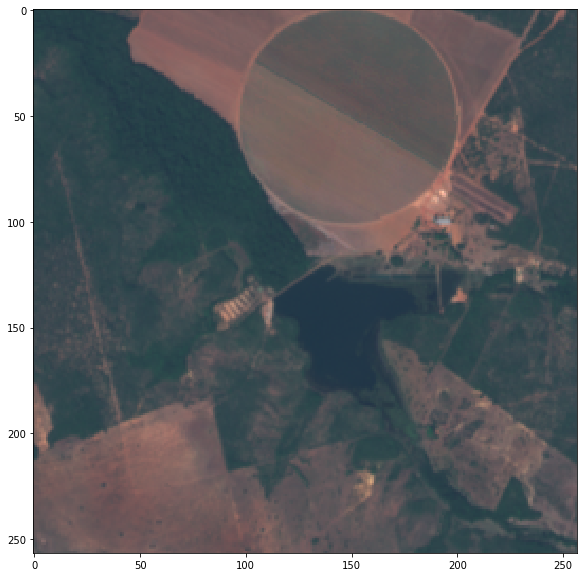

In [11]:
for image,y_batch in dataset.take(1):
    image = image[0,...]
    #print(y_batch)

    #all_objs = all_objs[0]
    #bbox = BoundBox(all_objs.numpy()[0],all_objs.numpy()[2] , all_objs.numpy()[1], all_objs.numpy()[3] )


# get bounding boxes in matplotlib format
#plt_boxes = get_matplotlib_boxes([bbox],image.numpy().shape)
# visualize image and bounding box
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, aspect='equal')
plt.imshow(image.numpy()[:,:,0:3].squeeze(), cmap='gray')

print("the bounding box is supposed to be wrong when augmented since it is not the transformed box")
#or plt_box in plt_boxes:
#    ax.add_patch(plt_box)
#    #ax.imshow(pixel_label)
#plt.show()

In [12]:
# with pretrained backend
history = yolo.train(train_imgs = input_files[0:50],
               valid_imgs = input_files[50:55],
               train_times= 1,
               valid_times= 1,
               nb_epochs= 25,
               learning_rate= 0.0001,
               batch_size= 10,
               warmup_epochs= 3 ,
               object_scale= 10.0,
               no_object_scale=3.0,
               coord_scale=1.0,
               class_scale=1.0)

Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
Use `tf.cast` instead.



Epoch 00000: Learning rate is 0.000001.
Epoch 1/28
499/500 [============================>.] - ETA: 0s - loss: 13071063.0120 - l_coord: 13069537.0000 - l_obj: 1516.9456 - l_class: 0.0000e+00
Epoch 00001: val_loss improved from inf to 6119061.91408, saving model to best_weights_bestLoss.h5
tp and fp: 12.0 40861.0


precision, recall, f1: 0.0002935923470261542 0.024 0.0005800884634906823


dam 0.0000
mAP: 0.0000
mAP improved from 0 to 9.107267813985882e-06, saving model to best_weights_bestMap.h5.
500/500 [==============================] - 463s 926ms/step - loss: 13045261.9055 - l_coord: 13043736.0000 - l_obj: 1516.7650 - l_class: 0.0000e+00 - val_loss: 6119061.9141 - val_l_coord: 6117659.0000 - val_l_obj: 1403.4620 - val_l_class: 0.0000e+00

Epoch 00001: Learning rate is 0.000004.
Epoch 2/28
499/500 [============================>.] - ETA: 0s - loss: 7209372.0122 - l_coord: 7208087.5000 - l_obj: 1284.8256 - l_class: 0.0000e+00
Epoch 00002: val_loss improved from 6119061.91408 to 303528.3

/vol/tensusers2/sdooper/dam_detection/keras_yolo_1/keras_yolov2/utils.py:231: RuntimeWarning: overflow encountered in exp
  return 1. / (1. + np.exp(-x))


tp and fp: 0.0 78.0


precision, recall, f1: 0.0 0.0 nan


dam 0.0000
mAP: 0.0000
mAP did not improve from 3.846153846153846e-05.
500/500 [==============================] - 386s 771ms/step - loss: 1102.3554 - l_coord: 646.8541 - l_obj: 455.5015 - l_class: 0.0000e+00 - val_loss: 377.9162 - val_l_coord: 33.0416 - val_l_obj: 344.8745 - val_l_class: 0.0000e+00

Epoch 00005: Learning rate is 0.000036.
Epoch 6/28


/vol/tensusers2/sdooper/dam_detection/keras_yolo_1/keras_yolov2/map_evaluation.py:55: RuntimeWarning: invalid value encountered in double_scalars
  f1 = (2 * precision * recall) / (precision + recall)


499/500 [============================>.] - ETA: 0s - loss: 435.6608 - l_coord: 166.5033 - l_obj: 269.1577 - l_class: 0.0000e+00
Epoch 00006: val_loss improved from 377.91618 to 197.06587, saving model to best_weights_bestLoss.h5
tp and fp: 3.0 62.0


precision, recall, f1: 0.046153846153846156 0.006 0.010619469026548674


dam 0.0005
mAP: 0.0005
mAP improved from 3.846153846153846e-05 to 0.000508611955420466, saving model to best_weights_bestMap.h5.
500/500 [==============================] - 390s 780ms/step - loss: 435.2323 - l_coord: 166.1888 - l_obj: 269.0436 - l_class: 0.0000e+00 - val_loss: 197.0659 - val_l_coord: 10.8216 - val_l_obj: 186.2443 - val_l_class: 0.0000e+00

Epoch 00006: Learning rate is 0.000049.
Epoch 7/28
499/500 [============================>.] - ETA: 0s - loss: 450.0477 - l_coord: 307.8997 - l_obj: 142.1478 - l_class: 0.0000e+00
Epoch 00007: val_loss improved from 197.06587 to 107.27386, saving model to best_weights_bestLoss.h5
tp and fp: 5.0 45.0


precision, recal

In [14]:
0.00001

1e-05

In [ ]:
# tensorboard metrics same tags keras
for i, (image,y_batch) in enumerate(dataset.take(1)):
    z = image
    y = y_batch
    print(np.squeeze(z.numpy()).shape)

In [13]:
for image, bbox, class_name, labels in dataset.take(1):
    print(class_name)
    print(labels)
    


ValueError: not enough values to unpack (expected 4, got 2)

In [12]:
def load_annotation(bbox, class_name, labels=['dam_image']):
    bbox = np.squeeze(bbox.numpy())
    class_name = np.squeeze(class_name.numpy(), axis=0)
    class_name = [x.decode("utf-8") for x in class_name]
    class_name = [labels.index(x) for x in class_name] # convert to integers
    all_objs = np.array([np.concatenate([bbox, class_name], axis=0)])
    
    # this is a conversion to xmin ymin xmax ymax!!!
    # DOES NOT WORK FOR MULTIPLE OBJECTS IN ONE IMAGE
    # but then again, the entire program is not build for it :)
    
    annots = []
    for obj in all_objs:
        annot = [obj[0], obj[2], obj[1], obj[3], obj[4]]
        annots += [annot]

    if len(annots) == 0:
        annots = [[]]

    return np.array(annots)
    


load_annotation(bbox, class_name)

NameError: name 'bbox' is not defined

## Generate anchor boxes for dataset

In [14]:
def stretch_image_colorspace(img):
    max_val = tf.reduce_max(img)
    return tf.cast(tf.divide(img, max_val), tf.float32)


def parse_features(feature):
    features = [feature[x] for x in ['image/width', 'image/height', 'image/filename', 'image/object/class/label']]
    col_channel = [feature[x] for x in ['image/channel/B4', 'image/channel/B3', 'image/channel/B2']]
    mndwi_chan = [feature[x] for x in ['image/channel/MNDWI']]
    ave_chan = [feature[x] for x in ['image/channel/AVE']]
    
    # locations
    obj = tf.stack([tf.sparse.to_dense(feature['image/object/bbox/xmin']),
                    tf.sparse.to_dense(feature['image/object/bbox/xmax']),
                    tf.sparse.to_dense(feature['image/object/bbox/ymin']),
                    tf.sparse.to_dense(feature['image/object/bbox/ymax'])
                    ], axis=1)
    
    pixel_label = feature['image/channel/PIXEL_LABEL']
    img = tf.transpose(tf.squeeze(tf.stack(col_channel)) , perm=[1, 2, 0])
    img = stretch_image_colorspace(img)
    
    
    # MNDWI normalization
    mndwi_chan = tf.divide(tf.add(mndwi_chan, 1), 1 + 1)
    img = tf.concat([img, tf.transpose(mndwi_chan, perm=[1,2,0])], axis= 2)
        
    # AVE normalization
    ave_chan = tf.divide(tf.add(ave_chan, 479) ,479 + 8859)
    img = tf.concat([img, tf.transpose(ave_chan, perm=[1,2,0])], axis= 2)
    
    return obj, pixel_label, img

In [25]:
dataset = tf.data.TFRecordDataset(input_files, compression_type='GZIP')
dataset = dataset.map(parse_serialized_example)
# [xmin, xmax, ymax, ymin]
#parse features extracts the bounding boxes

dataset = dataset.map(parse_features)
dataset = dataset.apply(tf.data.experimental.ignore_errors())

#for i, (gt, pixel_label, img) in enumerate(dataset):
#    print(i, gt)

### Functions from gen_anchors.py

In [26]:
num_anchors = 10

img_width = 257
img_height = 257

# if config = tfrecord

input_size = (config['model']['input_size_h'], config['model']['input_size_w'], 3)
feature_extractor = import_feature_extractor(config['model']['backend'], input_size)
grid_w = config['model']['input_size_w']/feature_extractor.get_output_shape()[1]
grid_h = config['model']['input_size_h']/feature_extractor.get_output_shape()[0]

print("grid_w, grid_h = ({},{})".format(grid_w,grid_h))

# run k_mean to find the anchors
annotation_dims = []

for labels, pixel_label, img in dataset:
    for label in labels:
        label = label.numpy()
        if label[0] == label[1] or label[2] ==label[3]:
            continue

        cell_w = img_width / grid_w
        cell_h = img_height / grid_h

        # 0: xmin, 1: xmax, 2: ymin, 3:ymax
        relative_w = (float(label[1]) - float(label[0]))/config['model']['input_size_w']
        relative_h = (float(label[3]) - float(label[2]))/config['model']['input_size_w']
        annotation_dims.append(tuple(map(float, (relative_w, relative_h))))
    
annotation_dims = np.array(annotation_dims)

''''''

loading backend weights
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputlayer_0 (InputLayer)    [(None, 257, 257, 5)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 257, 257, 3)       18        
_________________________________________________________________
resnet50 (Model)             multiple                  23587712  
Total params: 23,587,730
Trainable params: 23,534,610
Non-trainable params: 53,120
_________________________________________________________________
Using a custom backend called custom_backend.ResNet50CustomFeature.
grid_w, grid_h = (28.555555555555557,28.555555555555557)


''

In [27]:
annotation_dims = np.array(annotation_dims)
print(annotation_dims)
print(annotation_dims.shape)

[[0.05447471 0.05836576]
 [0.13618677 0.05836576]
 [0.47470817 0.16731518]
 ...
 [0.10505837 0.16731518]
 [0.28015564 0.31906615]
 [0.08171206 0.06614786]]
(27267, 2)


 ## k means functions

In [28]:
#utility functions for K-means
import numpy as np


def iou(box, clusters):
    """
    Calculates the Intersection over Union (IoU) between a box and k clusters.
    :param box: tuple or array, shifted to the origin (i. e. width and height)
    :param clusters: numpy array of shape (k, 2) where k is the number of clusters
    :return: numpy array of shape (k, 0) where k is the number of clusters
    """
    x = np.minimum(clusters[:, 0], box[0])
    y = np.minimum(clusters[:, 1], box[1])
    if np.count_nonzero(x == 0) > 0 or np.count_nonzero(y == 0) > 0:
        raise ValueError("Box has no area")

    intersection = x * y
    box_area = box[0] * box[1]
    cluster_area = clusters[:, 0] * clusters[:, 1]

    iou_ = intersection / (box_area + cluster_area - intersection)

    return iou_


def avg_iou(boxes, clusters):
    """
    Calculates the average Intersection over Union (IoU) between a numpy array of boxes and k clusters.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param clusters: numpy array of shape (k, 2) where k is the number of clusters
    :return: average IoU as a single float
    """
    return np.mean([np.max(iou(boxes[i], clusters)) for i in range(boxes.shape[0])])


def translate_boxes(boxes):
    """
    Translates all the boxes to the origin.
    :param boxes: numpy array of shape (r, 4)
    :return: numpy array of shape (r, 2)
    """
    new_boxes = boxes.copy()
    for row in range(new_boxes.shape[0]):
        new_boxes[row][2] = np.abs(new_boxes[row][2] - new_boxes[row][0])
        new_boxes[row][3] = np.abs(new_boxes[row][3] - new_boxes[row][1])
    return np.delete(new_boxes, [0, 1], axis=1)

def print_anchors(centroids):
    anchors = centroids.copy()

    widths = anchors[:, 0]
    sorted_indices = np.argsort(widths)

    r = "anchors: ["
    for i in sorted_indices[:-1]:
        r += '%0.5f,%0.5f, ' % (anchors[i, 0], anchors[i, 1])

    # there should not be comma after last anchor, that's why
    r += '%0.5f,%0.5f' % (anchors[sorted_indices[-1:], 0], anchors[sorted_indices[-1:], 1])
    r += "]"

    print(r)

def kmeans(boxes, k, dist=np.median, verbose=True):
    """
    Calculates k-means clustering with the Intersection over Union (IoU) metric.
    :param boxes: numpy array of shape (r, 2), where r is the number of rows
    :param k: number of clusters
    :param dist: distance function
    :return: numpy array of shape (k, 2)
    """
    rows = boxes.shape[0]

    distances = np.empty((rows, k))
    last_clusters = np.zeros((rows,))
    old_distances = distances
    np.random.seed()

    # the Forgy method will fail if the whole array contains the same rows
    clusters = boxes[np.random.choice(rows, k, replace=False)]
    
    # if inf or nan values: one or more clusters have no assignments out of all data points
    # quite rare, but not impossible
    iteration = 0
    while True:
        for row in range(rows):
            distances[row] = 1 - iou(boxes[row], clusters)
            
        iteration += 1
        if verbose:
            print("iteration {}: old: {}, new: {}, diff {}".format(iteration, np.sum(old_distances), np.sum(distances), np.sum(np.abs(old_distances-distances))))
        
        nearest_clusters = np.argmin(distances, axis=1)
        
        
        if (last_clusters == nearest_clusters).all():
            break
        for cluster in range(k):

            clusters[cluster] = dist(boxes[nearest_clusters == cluster], axis=0)

        last_clusters = nearest_clusters
        old_distances = distances.copy()
        
        
    return clusters, nearest_clusters

In [58]:
num_anchors = 15
num_iter = 10

best_anchors = dict()
best_iou = dict()
best_clusters = dict()

for num_anchor in range(2, num_anchors + 1):
    print("calculating centroids for {} centroids".format(num_anchor))
    cur_best = 0
    for i in range(num_iter):
        centroids, nearest_clusters = kmeans(annotation_dims, num_anchor, verbose=False)
        iou_score = avg_iou(annotation_dims, centroids)
        print('\naverage IOU for', num_anchor, 'anchors:', '%0.2f' % avg_iou(annotation_dims, centroids))
        
        # current iou score within iteration is improved
        if cur_best < iou_score and iou_score < 1:
            print("best score changed from {} to {}".format(cur_best, iou_score))
            cur_best = iou_score
            best_anchors[str(num_anchor)] = centroids     
            best_iou[str(num_anchor)] = cur_best
            best_clusters[str(num_anchor)] = nearest_clusters

calculating centroids for 14 centroids

average IOU for 14 anchors: 0.70
best score changed from 0 to 0.704622913207911

average IOU for 14 anchors: 0.71
best score changed from 0.704622913207911 to 0.7066119438144676

average IOU for 14 anchors: 0.71
best score changed from 0.7066119438144676 to 0.7108646104031465

average IOU for 14 anchors: 0.71

average IOU for 14 anchors: 0.71

average IOU for 14 anchors: 0.71

average IOU for 14 anchors: 0.71

average IOU for 14 anchors: 0.71

average IOU for 14 anchors: 0.71

average IOU for 14 anchors: 0.71
calculating centroids for 15 centroids

average IOU for 15 anchors: 460923266984.34

average IOU for 15 anchors: 0.71
best score changed from 0 to 0.7148783911057143

average IOU for 15 anchors: 0.71

average IOU for 15 anchors: 0.72
best score changed from 0.7148783911057143 to 0.717421755286339

average IOU for 15 anchors: 0.72

average IOU for 15 anchors: 0.72

average IOU for 15 anchors: 0.71

average IOU for 15 anchors: 0.72
best score 

In [68]:
for i, (key,values) in enumerate(best_anchors.items()):
    print("best anchors for {} anchors is".format(key))
    print_anchors(values)
    
for i, (key,values) in enumerate(best_iou.items()):
    print("best iou for {} is".format(key))
    print(values)

best anchors for 2 anchors is
anchors: [0.05837,0.05058, 0.19066,0.15953]
best anchors for 3 anchors is
anchors: [0.05058,0.04280, 0.10895,0.08949, 0.27626,0.23346]
best anchors for 4 anchors is
anchors: [0.03891,0.06615, 0.06615,0.03502, 0.11673,0.09339, 0.28405,0.24125]
best anchors for 5 anchors is
anchors: [0.03502,0.05837, 0.06615,0.03113, 0.08949,0.07004, 0.15953,0.13619, 0.36576,0.31907]
best anchors for 6 anchors is
anchors: [0.03502,0.05058, 0.05837,0.09728, 0.06615,0.02724, 0.10506,0.05837, 0.16342,0.13230, 0.36187,0.31907]
best anchors for 7 anchors is
anchors: [0.03113,0.05058, 0.05447,0.08560, 0.06226,0.02724, 0.09728,0.05058, 0.13619,0.10117, 0.21012,0.19844, 0.47860,0.36965]
best anchors for 8 anchors is
anchors: [0.03113,0.05837, 0.05837,0.03113, 0.06226,0.08949, 0.09728,0.04669, 0.10506,0.16732, 0.16342,0.08949, 0.24903,0.19066, 0.47471,0.41245]
best anchors for 9 anchors is
anchors: [0.02724,0.07004, 0.03891,0.04280, 0.05837,0.08171, 0.06615,0.02724, 0.09339,0.04669, 

0


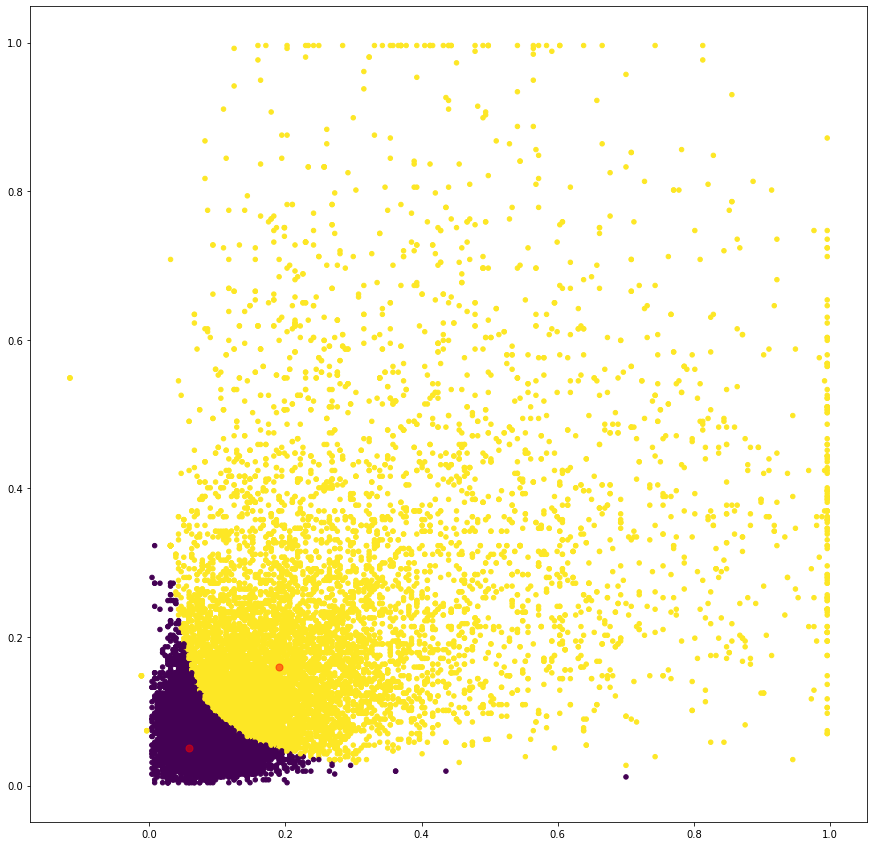

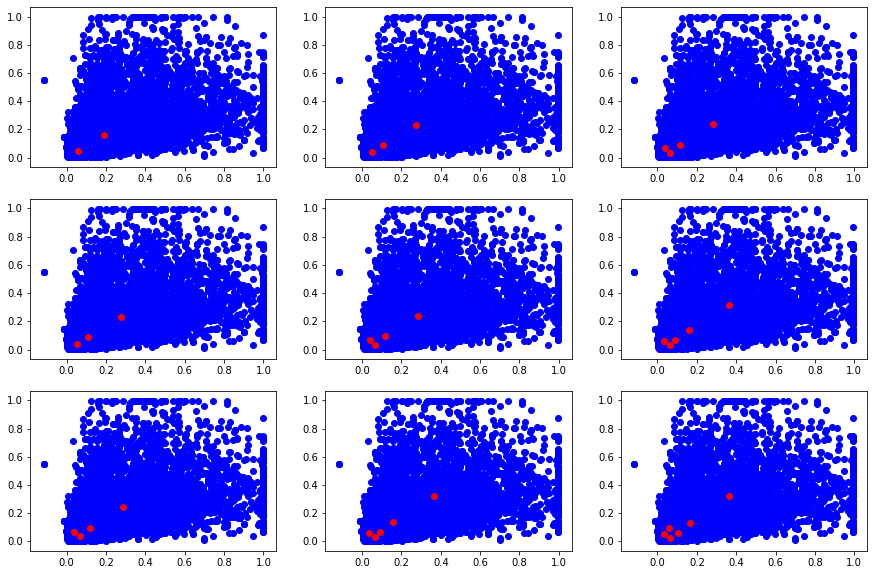

In [79]:
idx = '2'
nearest_clusters = best_clusters[idx]
LABEL_COLOR_MAP = {0 : 'b',
                   1 : 'g',
                   2 : 'r',
                   3 : 'c',
                   4 : 'm',
                   5 : 'y',
                   6 : 'k',
                   7 : '#eeefff',
                   8 : '#eeffff',
                   9 : '#efffff'
                   }
print(np.min(nearest_clusters))
label_color = [LABEL_COLOR_MAP[l] for l in nearest_clusters]

plt.figure(figsize= (15,15))
plt.scatter(annotation_dims[:,0], annotation_dims[:,1], c=nearest_clusters, s=20, cmap='viridis')
plt.scatter(best_anchors[idx][:,0], best_anchors[idx][:,1],c='red', s=50, cmap='viridis', alpha=0.5 )
#plt.colorbar()
fig, axes = plt.subplots(3,3)

fig.set_figwidth(15)
fig.set_figheight(10)
for i in range(3):
    for j in range(3):
        axes[i,j].scatter(annotation_dims[:,0], annotation_dims[:,1], c='b')
        axes[i,j].scatter(best_anchors[str(i+j+2)][:,0], best_anchors[str(i+j+2)][:,1], c='r')


In [64]:
print_anchors(best_anchors['5'])
print(" normal anchor box", (best_anchors['5']))
print(" transformed anchor box", (best_anchors['5'] * 9))

anchors: [0.03502,0.05837, 0.06615,0.03113, 0.08949,0.07004, 0.15953,0.13619, 0.36576,0.31907]
 normal anchor box [[0.08949416 0.07003891]
 [0.03501946 0.05836576]
 [0.36575875 0.31906615]
 [0.15953307 0.13618677]
 [0.06614786 0.0311284 ]]
 transformed anchor box [[0.80544747 0.63035019]
 [0.3151751  0.52529183]
 [3.29182879 2.87159533]
 [1.43579767 1.22568093]
 [0.59533074 0.28015564]]


Text(0, 0.5, 'avg IOU')

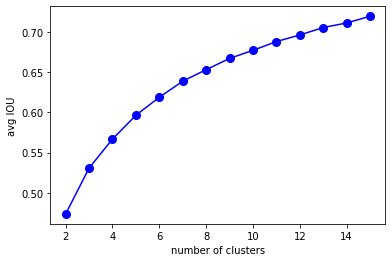

In [98]:
np.arange(2,16)
ious = np.array([x for x in best_iou.values()])

plt.plot(np.arange(2,16), ious, 
         linestyle='-', 
         marker='o', 
         color='b',
         markersize=8)
plt.xlabel('number of clusters')
plt.ylabel('Avg IOU')


### Anchor visualization


In [ ]:
import cv2
import matplotlib.patches as patches

In [ ]:
class BoundingBox:
    def __init__(self, x, y, w, h, c = None, classes = None):
        self.x     = x
        self.y     = y
        self.w     = w
        self.h     = h
        
        self.c     = c
        self.classes = classes

        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)        
        return self.label
    
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
        return self.score

def get_matplotlib_boxes(boxes, img_shape):
    plt_boxes = []
    for box in boxes:
        xmin  = int((box.x - box.w/2) * img_shape[1])
        xmax  = int((box.x + box.w/2) * img_shape[1])
        ymin  = int((box.y - box.h/2) * img_shape[0])
        ymax  = int((box.y + box.h/2) * img_shape[0])        
        plt_boxes.append(patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, fill=False, color='#00FF00', linewidth='2'))
    return plt_boxes

In [ ]:
# plot image and bounding boxes for sanity check
img = np.zeros((257,257,1)) 
#get bounding boxes in matplotlib format


boxes = [0.14786,0.20233, 0.21790,0.38911, 0.23346,0.11673, 0.30739,0.19066, 0.47471,0.32296] 
bbox = [BoundingBox(0.5, 0.5, boxes[2 * i], boxes[2 * i + 1]) for i in range(int(len(boxes) /2)) ]


plt_boxes = get_matplotlib_boxes(bbox,img.shape)

# visualize image and bounding box
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, aspect='equal')
plt.imshow(img.squeeze(), cmap='binary')
for plt_box in plt_boxes:
    ax.add_patch(plt_box)
    #plt.axis('off')
plt.show()

## bounding box correctness


In [21]:

dataset = tf.data.TFRecordDataset(input_files[0:3], compression_type='GZIP')
dataset = dataset.map(parse_serialized_example)
# [xmin, xmax, ymax, ymin]
#parse features extracts the bounding boxes

dataset = dataset.map(parse_features)


0
tf.Tensor([120 136 118 137], shape=(4,), dtype=int64)
nr objects 1
labeled [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


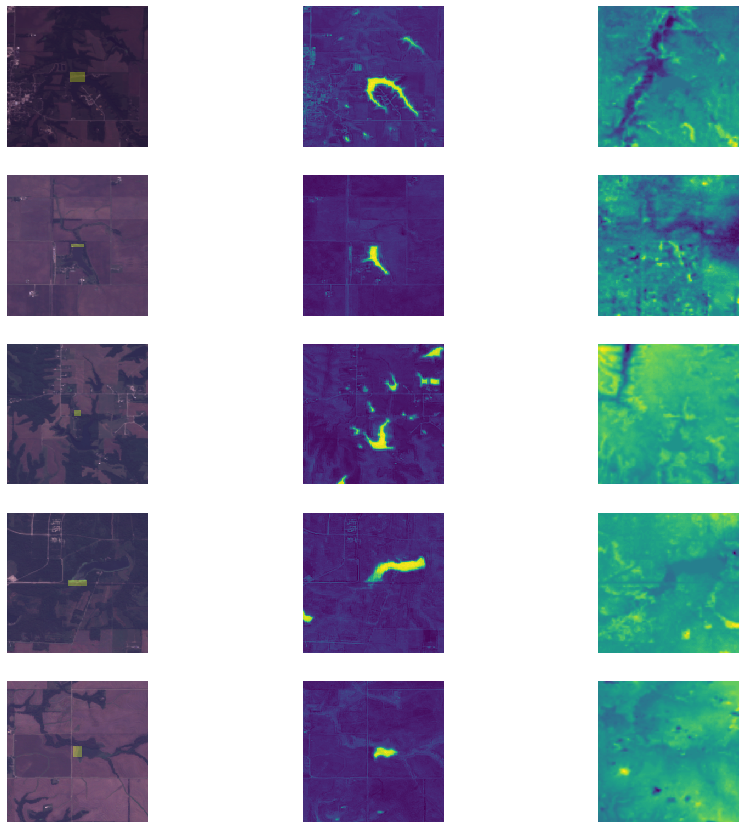

In [30]:
from scipy import ndimage

images = []
gt_boxes = []
for i, (x, gt, img) in enumerate(dataset.take(5)):
    images.append(img)
    gt_boxes.append(gt)
    if i% 100 == 0:
        print(i)

print(x)

labeled, nr_objects = ndimage.label(gt.numpy()) 
print("nr objects", nr_objects)
print("labeled", labeled)

fig, axes = plt.subplots(5,3)
fig.set_figheight(15)
fig.set_figwidth(15)

for i in range(5):
    axes[i,0].imshow(gt_boxes[i])
    axes[i,0].imshow(images[i][:,:,0:3], alpha=0.7)
    axes[i,0].axis('off')
    axes[i,1].imshow(images[i][:,:,3])
    axes[i,1].axis('off')
    axes[i,2].imshow(images[i][:,:,4])
    axes[i,2].axis('off')
    
plt.show()    

## How to deal with multiple segments in one image?
a solution is to run a connected components algorithm and divide them that way. Not implemented yet

## TODO EN FOUTEN
overlapping samples in GEE
Testing areas
Alle overlapping areas weghalen
object detector testen met loss scales en augmentation